In [ ]:
!pip install -q transformers datasets torch torchvision albumentations roboflow pytorch_lightning

# init

In [31]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import pytorch_lightning as pl
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF


BASE_PATH = "/home/ubuntu/work/carvana/dataset/"

# Hyperparameters etc.
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 8
NUM_EPOCHS = 1
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 original
IMAGE_WIDTH = 240  # 1918 original
PIN_MEMORY = True
LOAD_MODEL = False



# Dataset

In [32]:

class CarvanaDataset(Dataset):
    def __init__(self, root_dir, transform=None):     
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = os.listdir(self.root_dir)    
        self.images = list(filter(lambda x: "jpg" in x, self.images))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        mask_path = os.path.join(self.root_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image1 = augmentations['image']
            # assert image1.shape == image.shape, f"{ image1.shape},  {image.shape}"
            mask1 = augmentations['mask']
            
        return image1,mask1
        

In [33]:
train_transform = A.Compose(
    [
        A. Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A. Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


In [34]:
train_ds = CarvanaDataset(
    root_dir=os.path.join(BASE_PATH,"train"),
    transform=train_transform,
)

train_loaders = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = CarvanaDataset(
    root_dir=os.path.join(BASE_PATH,"valid"),

    transform=val_transform,
)
val_loaders = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)


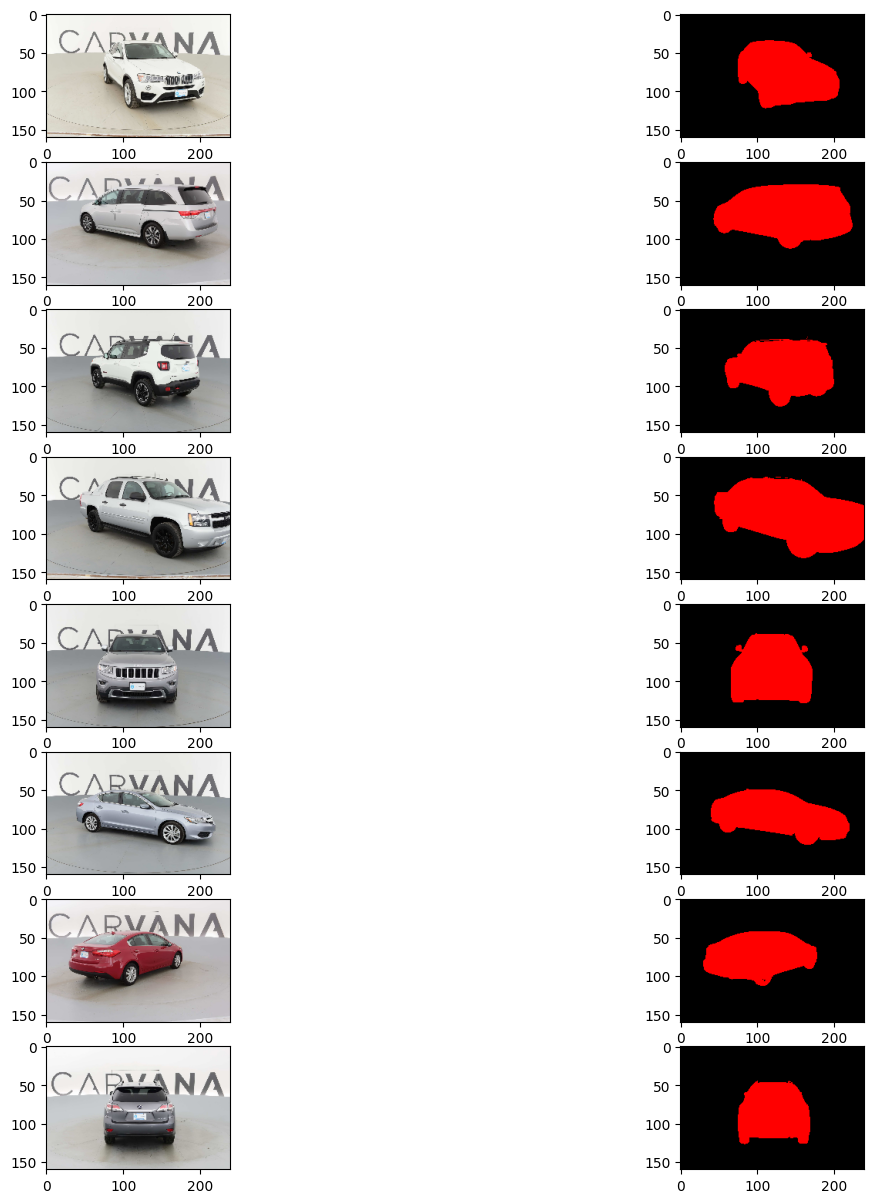

In [35]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in train_loaders:
    images, masks = batch
    break

n_plots = 8
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)

for i in range(n_plots):
    image =images[i,:,:].permute(1, 2, 0)
    axarr[i,0].imshow(image)
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

# Unet model

In [37]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel, stride, padding - same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # kernel, stride, padding - same convolution
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self,
                 in_channels=3, out_channels=1,
                 features=[64, 128, 256, 512]
                 ) -> None:
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    pred = model(x)
    print(pred.shape)
    print(x.shape)
    assert pred.shape == x.shape


if __name__ == "__main__":
    test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Train

In [29]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)


NameError: name 'UNET' is not defined

In [15]:
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    max_epochs=NUM_EPOCHS,
    # precision=16
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, train_loaders, val_loaders)


Missing logger folder: /home/ubuntu/work/tstSegFormer/lightning_logs
2024-03-26 08:11:20.472326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 08:11:22.451342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name        | Type               | Params
---------------------------------------------------
0 | downs       | ModuleList         | 4.7 M 
1 | ups         | ModuleList         | 12.2 M
2 | pool        | MaxPool2d          | 0     
3 | bottleneck  | DoubleConv         | 14.2 M
4 | final_conv  | Conv2d             | 65    
5 | loss_fn     | BCEWithLogitsLoss  | 0     
6 | accuracy    | MulticlassAccuracy | 0     
7 | my_accuracy | MyAccuracy         | 0     
----------------------------

Epoch 0:   1%|          | 6/573 [01:40<2:38:49,  0.06it/s, v_num=0, loss=0.546, accuracy=0.866, dice_score=0.688]

/home/ubuntu/miniconda3/envs/LayoutLMv3/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


 # view results

In [11]:
loader = val_loaders
folder="./save_images"
device=DEVICE

try:
    os.mkdir(folder)
except FileExistsError:
    print("Directory ",folder," already exists")


In [12]:
for idx, (x, y) in enumerate(val_loaders):
    x = x.to(device=device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
    torchvision.utils.save_image(preds, os.path.join(folder,f"pred_{idx}.png"))
    torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder,f"correct_{idx}.png"))

In [13]:

for idx, (pixel_values,masks) in enumerate(val_loaders):
    print(idx, pixel_values.shape)
    preds = torch.sigmoid(model(pixel_values))
    predicted_mask = (preds > 0.5).float()
    masks = masks.cpu().numpy()
    break # only one batch


0 torch.Size([8, 3, 160, 240])


In [14]:
print("predicted_mask.shape",predicted_mask.shape)
print("masks.shape",masks.shape)

predicted_mask.shape torch.Size([8, 1, 160, 240])
masks.shape (8, 160, 240)


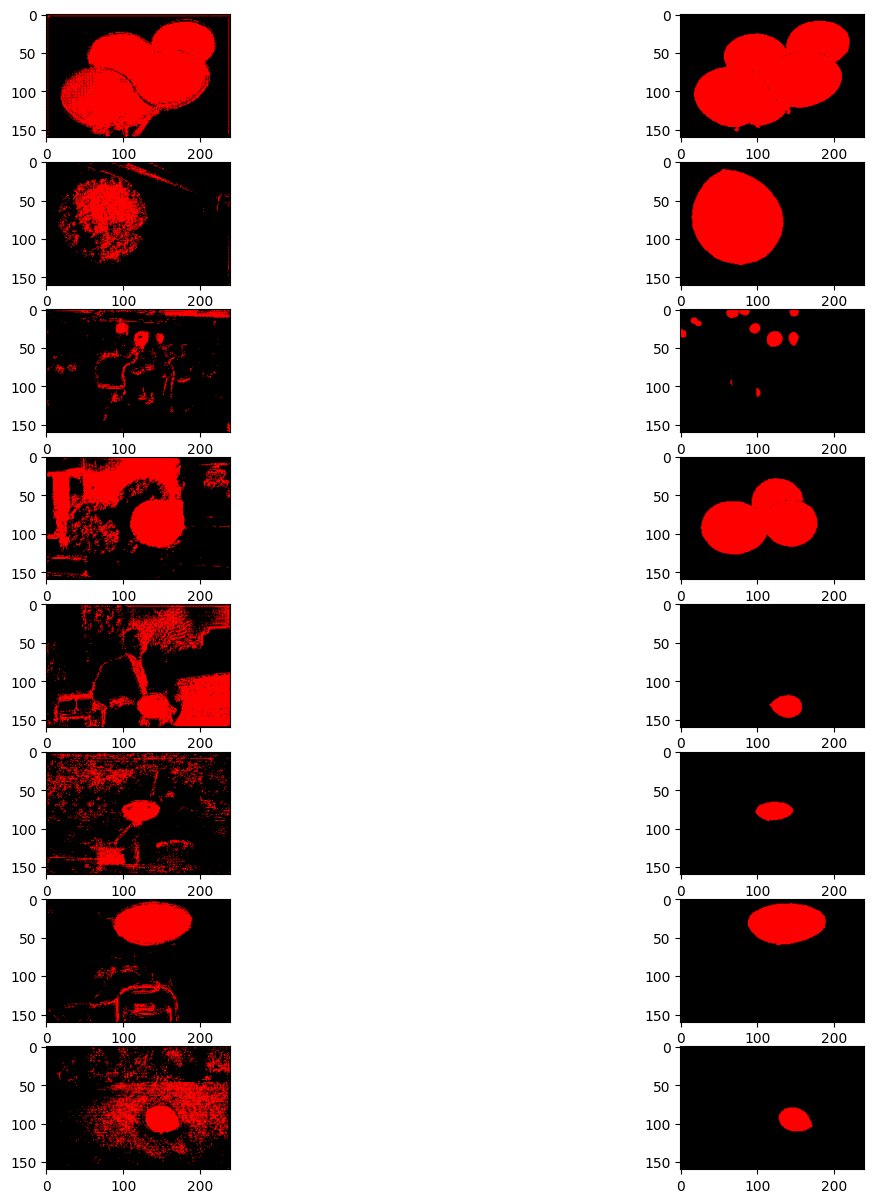

In [15]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8).squeeze())
n_plots = 8
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

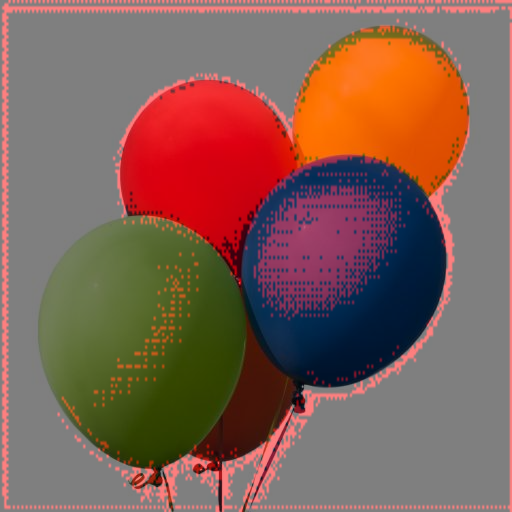

In [16]:
#Predict on a test image and overlay the mask on the original image
test_idx = 0
input_image_file = os.path.join(val_ds.root_dir,val_ds.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = val_ds[test_idx]
images, masks = test_batch
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = model(images)
preds = torch.sigmoid(outputs)
predicted_mask = (preds > 0.5).float()


mask = prediction_to_vis(predicted_mask[test_idx,:,:])
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img